In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'
import itertools
import matplotlib as mpl
from open_CMIP6_num_joint_extremes import open_CMIP6_num_joint_extremes, open_CMIP6_num_joint_extremes_wp

Load output of joint probability analysis:

In [2]:
ssps = ['ssp245','ssp585']

#load wind speed & precipitation:
numex_ds = open_CMIP6_num_joint_extremes_wp('/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_1p5/sfcWind_pr/40yr_p98_lag0d_declus1d_ref2000/',
                                            '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus1d_ref2000/',
                                            ssps)

num_joint_wp = numex_ds.num_joint_extremes.load() #load into memory
num_joint_wp_isect = num_joint_wp.where(np.isfinite(num_joint_wp).all(dim=['ssp','latitude','longitude']),drop=True) #get the intersection of members with both SSPs available

#load storm surge & precipitation:
numex_ds = open_CMIP6_num_joint_extremes('/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus1d_ref2000/',
                                         ssps)
num_joint_sp = numex_ds.num_joint_extremes.load()
num_joint_sp_isect = num_joint_sp.where(np.isfinite(num_joint_sp).all(dim=['ssp','tg']),drop=True) #members with both SSPs available

Select single-member multi-model ensemble (use the first finite member of each model)

In [3]:
finite_mems = np.isfinite(num_joint_wp_isect.isel(latitude=0,window=0,month=0,longitude=0,ssp=0))

members= np.zeros((len(num_joint_wp_isect.source_id)))
for i in np.arange(len(num_joint_wp_isect.source_id)):
    try:
        members[i] = np.where(finite_mems[i,:])[0][0]
    except:
        members[i] = 0
ix = xr.DataArray(members,dims=['source_id'],coords={'source_id':num_joint_wp_isect.source_id})

num_joint_wp_isect_1mem = num_joint_wp_isect.isel(member_id=ix.astype('int')).dropna(dim='source_id')
num_joint_sp_isect_1mem = num_joint_sp_isect.isel(member_id=ix.astype('int')).dropna(dim='source_id')

Do the analysis & plot:

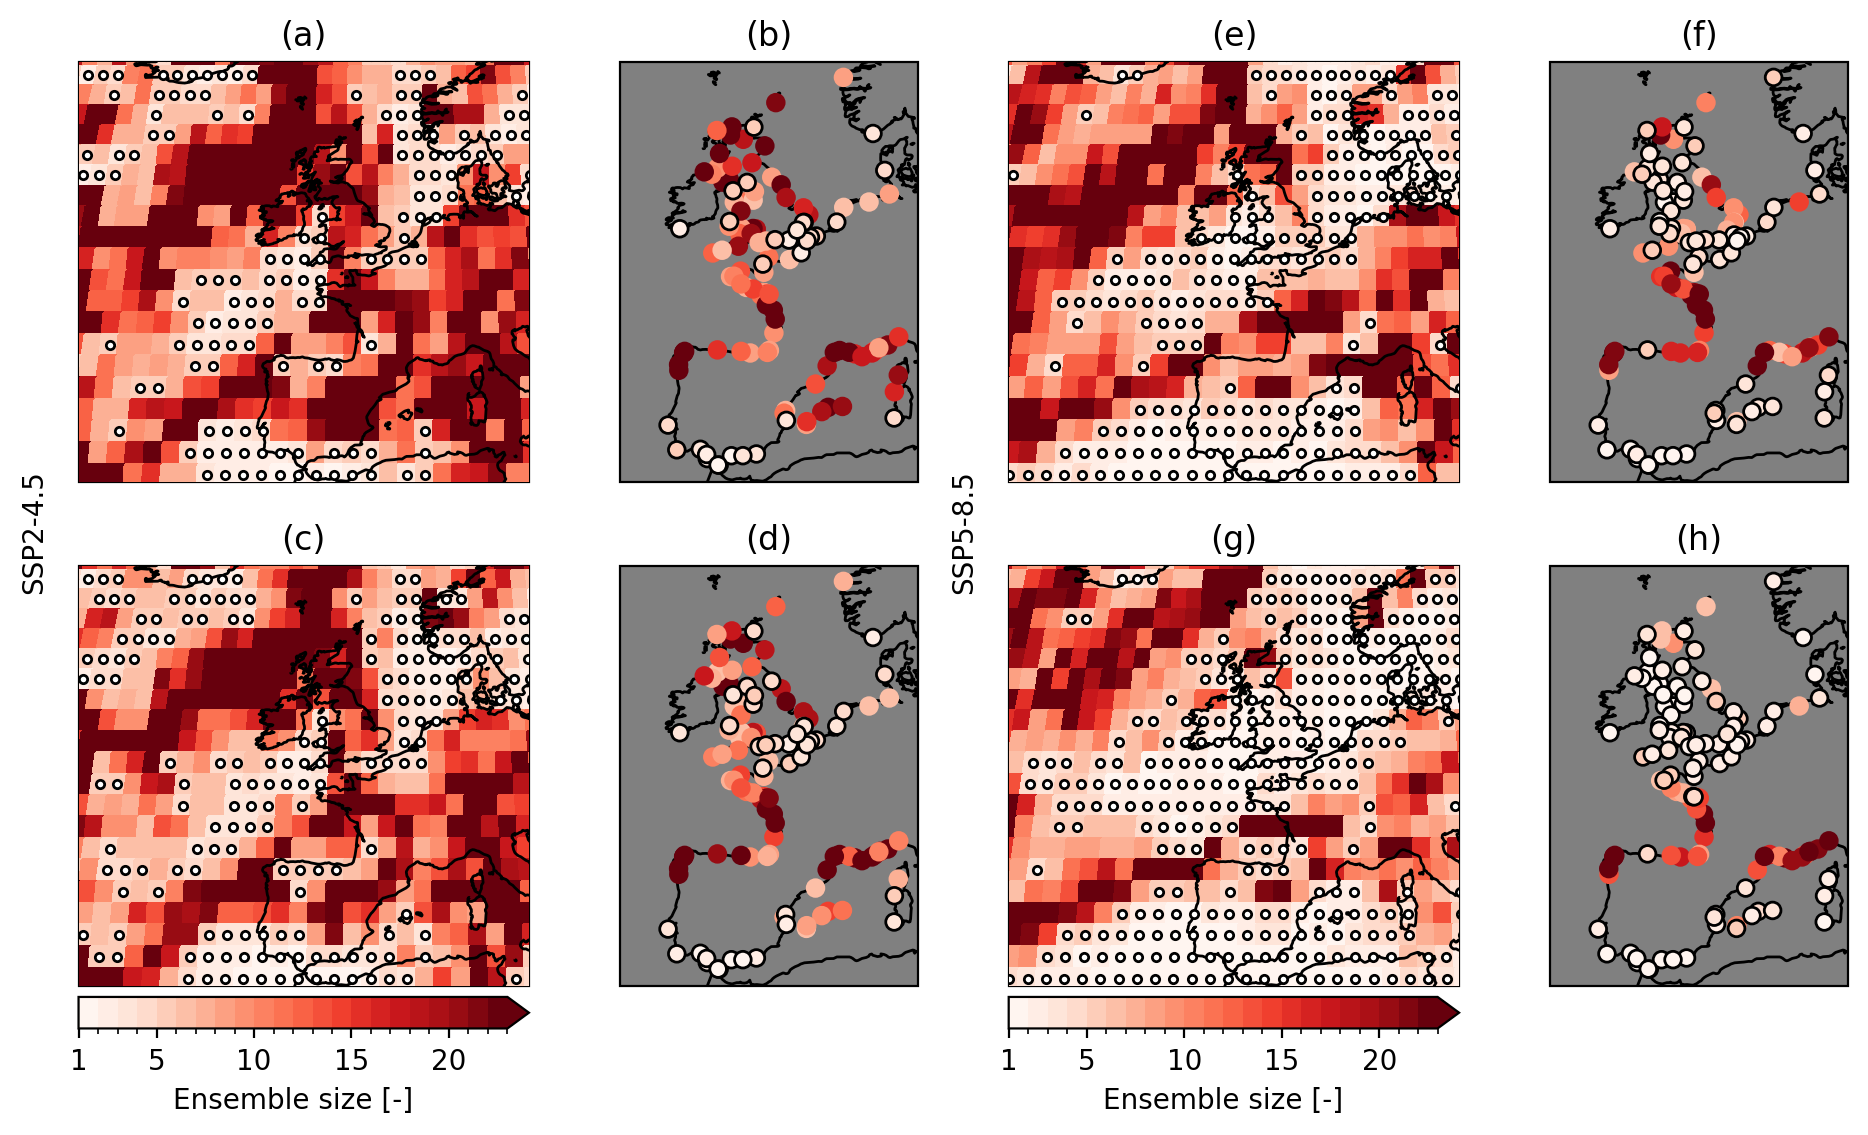

In [5]:
enssizes = np.arange(1,len(num_joint_wp_isect_1mem.source_id)) #sizes of subsets of models possible (1 to n-1)
frac_threshold = .9 #required fraction of ensemble means to agree in sign

#generate discrete colormap
cmap = plt.cm.Reds # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(1, enssizes[-1], enssizes[-1])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
       
np.random.seed(seed=0) #set random seed for selecting random ensembles

fig=plt.figure(figsize=(12,6)) #generate figure  
gs = fig.add_gridspec(2,6)
gs.update(wspace=.001)

for s,ssp in enumerate(['ssp245','ssp585']):
    for w,window in enumerate(np.array([2060,2080])):
        ensmean_dn_wp = (num_joint_wp_isect.sel(ssp=ssp).sel(window=window).sum(dim='month',skipna=True) - num_joint_wp_isect.sel(ssp=ssp).sel(window=2000).sum(dim='month',skipna=True)).mean(dim='member_id').mean(dim='source_id')
        ensmean_dn_sp = (num_joint_sp_isect.sel(ssp=ssp).sel(window=window).sum(dim='month',skipna=True) - num_joint_sp_isect.sel(ssp=ssp).sel(window=2000).sum(dim='month',skipna=True)).mean(dim='member_id').mean(dim='source_id')
        
        #generate random indices of subsets of s CMIP6 models
        n_samps = 5000
        for n_models in enssizes: #for ensemble sizes of 1 to n-1:
            combs = list(itertools.combinations(np.arange(enssizes[-1]+1), n_models)) #get 5000 (or all) possible combinations of s CMIP6 models
            if len(combs)>n_samps:
                idx=np.random.randint(0,len(combs),size=n_samps)
                idx_ds = xr.DataArray(np.array([combs[k] for k in idx]),dims=['n','model'])
            else:
                idx_ds = xr.DataArray(np.array([combs[k] for k in np.arange(len(combs))]),dims=['n','model'])
        
            #compute fraction of subsets that agree in sign with full ensemble projections
            subsets_dn_wp = (num_joint_wp_isect_1mem.sel(ssp=ssp).sel(window=window).sum(dim='month',skipna=True).isel(source_id=idx_ds) - num_joint_wp_isect_1mem.sel(ssp=ssp).sel(window=2000).sum(dim='month',skipna=True).isel(source_id=idx_ds)).mean(dim='model')
            subsets_dn_sp = (num_joint_sp_isect_1mem.sel(ssp=ssp).sel(window=window).sum(dim='month',skipna=True).isel(source_id=idx_ds) - num_joint_sp_isect_1mem.sel(ssp=ssp).sel(window=2000).sum(dim='month',skipna=True).isel(source_id=idx_ds)).mean(dim='model')
            
            frac_sign_agree_wp = (np.sign(subsets_dn_wp) == np.sign(ensmean_dn_wp)).sum(dim='n')/len(subsets_dn_wp.n)
            frac_sign_agree_sp = (np.sign(subsets_dn_sp) == np.sign(ensmean_dn_sp)).sum(dim='n')/len(subsets_dn_sp.n)
            
            #store results into datasets
            if n_models==1:
                frac_sign_agree_wp_ds = frac_sign_agree_wp
                frac_sign_agree_sp_ds = frac_sign_agree_sp
            else:
                frac_sign_agree_wp_ds = xr.concat((frac_sign_agree_wp_ds,frac_sign_agree_wp),dim='n_models')
                frac_sign_agree_sp_ds = xr.concat((frac_sign_agree_sp_ds,frac_sign_agree_sp),dim='n_models')
        frac_sign_agree_wp_ds = frac_sign_agree_wp_ds.assign_coords({'n_models':enssizes})
        frac_sign_agree_sp_ds = frac_sign_agree_sp_ds.assign_coords({'n_models':enssizes})
        
        frac_exceeds_t_wp = (frac_sign_agree_wp_ds >=frac_threshold)
        frac_exceeds_t_sp = (frac_sign_agree_sp_ds >=frac_threshold)
        
        #find minimum n_models for which fraction of ensemble means agreeing in sign gt or eq to .90 and stays that for higher n_models
        #now with a for loop, could possibly be more efficient
        subsequent_sum_wp = frac_exceeds_t_wp.copy(deep=True)
        subsequent_sum_sp = frac_exceeds_t_sp.copy(deep=True)
        for k in np.arange(len(frac_exceeds_t_wp.n_models)):
            subsequent_sum_wp[k,...] = frac_exceeds_t_wp.isel(n_models=np.arange(k,len(frac_exceeds_t_wp.n_models))).all(dim='n_models').values
            subsequent_sum_sp[k,...] = frac_exceeds_t_sp.isel(n_models=np.arange(k,len(frac_exceeds_t_sp.n_models))).all(dim='n_models').values
       
        first_n_wp = ((frac_exceeds_t_wp * subsequent_sum_wp) >=frac_threshold).argmax(dim='n_models')+1
        first_n_sp = ((frac_exceeds_t_sp * subsequent_sum_sp) >=frac_threshold).argmax(dim='n_models')+1
        
        first_n_wp = first_n_wp.where((frac_sign_agree_wp_ds >=frac_threshold).any(dim='n_models'),enssizes[-1])
        first_n_sp = first_n_sp.where((frac_sign_agree_sp_ds >=frac_threshold).any(dim='n_models'),enssizes[-1])
        
        #do the plotting
        #sfcWind & pr
        if ssp=='ssp245':  
            ax = plt.subplot(gs[w,0:2],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

            sc = (first_n_wp).plot(cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
      
            [LON,LAT] = np.meshgrid(first_n_wp.longitude,first_n_wp.latitude)
            ax.scatter(LON.flatten()[first_n_wp.values.flatten()<6],LAT.flatten()[first_n_wp.values.flatten()<6],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=5)
            ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
            if w==1:
                cax=ax.inset_axes(bounds=(0, -.1,1,.075))
                cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Ensemble size [-]',extend='max')
                cb.set_ticks(np.array([1,5,10,15,20]))
                cb.set_ticklabels(['1','5','10','15','20'])
            ax.set_title(['(a)','(c)'][w])

            sc.set_edgecolor('face')
         
        
        if ssp=='ssp585':                                                                             
            ax = plt.subplot(gs[w,3:5],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            
        
            sc = (first_n_wp).plot(cmap=cmap,transform=ccrs.PlateCarree(),zorder=3,ax=ax,norm=norm,add_colorbar=False)
            
            [LON,LAT] = np.meshgrid(first_n_wp.longitude,first_n_wp.latitude)
            ax.scatter(LON.flatten()[first_n_wp.values.flatten()<6],LAT.flatten()[first_n_wp.values.flatten()<6],edgecolor='black',facecolor='white',transform=ccrs.PlateCarree(),zorder=7,marker='o',s=9)

            ax.coastlines(zorder=5)
            ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
            if w==1:
                cax=ax.inset_axes(bounds=(0, -.1,1,.075))
                cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Ensemble size [-]',extend='max')
                cb.set_ticks(np.array([1,5,10,15,20]))
                cb.set_ticklabels(['1','5','10','15','20'])
            ax.set_title(['(e)','(g)'][w])

            sc.set_edgecolor('face')
        if (w==0):
            ax.annotate(['SSP2-4.5','SSP5-8.5'][s],xy=(-.13,-.25),xycoords='axes fraction',rotation=90)  
                
        #surge & pr
        if ssp=='ssp245':                                                                             
            ax = plt.subplot(gs[w,2],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            sc=ax.scatter(first_n_sp.lon[first_n_sp<6],first_n_sp.lat[first_n_sp<6],c=first_n_sp[first_n_sp<6],cmap=cmap,norm=norm,edgecolor='black',transform=ccrs.PlateCarree(),zorder=4)
            sc=ax.scatter(first_n_sp.lon[first_n_sp>5],first_n_sp.lat[first_n_sp>5],c=first_n_sp[first_n_sp>5],cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3)

            ax.coastlines(zorder=1)
            
            ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
            
            ax.set_title(['(b)','(d)'][w])
            
            sc.set_edgecolor('face')
            
        if ssp=='ssp585':                                                                       
            ax = plt.subplot(gs[w,5],projection=ccrs.Robinson(central_longitude=0))

            ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
            sc=ax.scatter(first_n_sp.lon[first_n_sp<6],first_n_sp.lat[first_n_sp<6],c=first_n_sp[first_n_sp<6],cmap=cmap,norm=norm,edgecolor='black',transform=ccrs.PlateCarree(),zorder=4)
            sc=ax.scatter(first_n_sp.lon[first_n_sp>5],first_n_sp.lat[first_n_sp>5],c=first_n_sp[first_n_sp>5],cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),zorder=3)

            ax.coastlines(zorder=1)
            
            ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
           
            ax.set_title(['(f)','(h)'][w])

            sc.set_edgecolor('face')

#fig.savefig('Figures/req_enssize_cmip6.pdf',format='pdf',dpi=300,bbox_inches='tight')
